In [1]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
License(s): CC-BY-NC-SA-4.0
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0


In [3]:
!unzip -q lgg-mri-segmentation.zip -d ./lgg_mri_segmentation
!unzip -q brain-tumor-mri-dataset.zip -d ./brain_tumor_mri

In [4]:
import os
from glob import glob
import shutil

lgg_mri_path = "/content/lgg_mri_segmentation/lgg-mri-segmentation/kaggle_3m"
brain_tumor_train_path = "/content/brain_tumor_mri/Training"
brain_tumor_test_path = "/content/brain_tumor_mri/Testing"
combined_data_path = "/content/combined_data"

os.makedirs(combined_data_path, exist_ok=True)
os.makedirs(f"{combined_data_path}/tumor", exist_ok=True)
os.makedirs(f"{combined_data_path}/non_tumor", exist_ok=True)

def copy_images(source_path, dest_path, label):
    images = glob(f"{source_path}/**/*.jpg", recursive=True) + glob(f"{source_path}/**/*.png", recursive=True)
    for img in images:
        shutil.copy(img, f"{dest_path}/{label}/{os.path.basename(img)}")

copy_images(lgg_mri_path, combined_data_path, "tumor")
copy_images(brain_tumor_train_path, combined_data_path, "tumor")
copy_images(brain_tumor_test_path, combined_data_path, "tumor")

tumor_count = len(os.listdir(f"{combined_data_path}/tumor"))
non_tumor_count = len(os.listdir(f"{combined_data_path}/non_tumor"))

print(f"Tumor Images: {tumor_count}, Non-Tumor Images: {non_tumor_count}")

Tumor Images: 7023, Non-Tumor Images: 0


In [5]:
notumor_train_path = "/content/brain_tumor_mri/Training/notumor"
notumor_test_path = "/content/brain_tumor_mri/Testing/notumor"
non_tumor_dest = "/content/combined_data/non_tumor"

copy_images(notumor_train_path, "/content/combined_data", "non_tumor")
copy_images(notumor_test_path, "/content/combined_data", "non_tumor")

tumor_count = len(os.listdir(f"{combined_data_path}/tumor"))
non_tumor_count = len(os.listdir(f"{combined_data_path}/non_tumor"))

print(f"Updated Dataset - Tumor Images: {tumor_count}, Non-Tumor Images: {non_tumor_count}")

Updated Dataset - Tumor Images: 7023, Non-Tumor Images: 2000


In [6]:
import cv2
import numpy as np
from tqdm import tqdm

IMG_SIZE = 256

processed_tumor_path = "/content/combined_data/tumor"
processed_nontumor_path = "/content/combined_data/non_tumor"

def preprocess_images(folder_path):
    images = os.listdir(folder_path)
    for img_name in tqdm(images, desc=f"Processing {folder_path}"):
        img_path = os.path.join(folder_path, img_name)

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Grayscale
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))       # Resize
        img = img / 255.0                                  # Normalize

        cv2.imwrite(img_path, (img * 255).astype(np.uint8))

preprocess_images(processed_tumor_path)
preprocess_images(processed_nontumor_path)

print("Image preprocessing complete!")

Processing /content/combined_data/non_tumor: 100%|██████████| 2000/2000 [00:02<00:00, 810.49it/s]

Image preprocessing complete!


In [7]:
import cv2
import numpy as np
import os
import random

def basic_augment(img):
    # Random flip
    if random.random() > 0.5:
        img = cv2.flip(img, 1)

    # Random rotation
    angle = random.randint(-15, 15)
    h, w = img.shape
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))

    # Random brightness
    factor = random.uniform(0.8, 1.2)
    img = np.clip(img * factor, 0, 255).astype(np.uint8)

    return img

In [8]:
def balance_classes(tumor_dir, non_tumor_dir):
    tumor_imgs = os.listdir(tumor_dir)
    non_tumor_imgs = os.listdir(non_tumor_dir)

    if len(tumor_imgs) > len(non_tumor_imgs):
        src_dir = non_tumor_dir
        src_imgs = non_tumor_imgs
        target = len(tumor_imgs)
    elif len(tumor_imgs) < len(non_tumor_imgs):
        src_dir = tumor_dir
        src_imgs = tumor_imgs
        target = len(non_tumor_imgs)
    else:
        print("Dataset is already balanced.")
        return

    print(f"Augmenting {src_dir} to reach {target} images...")

    i = 0
    while len(os.listdir(src_dir)) < target:
        img_name = random.choice(src_imgs)
        img_path = os.path.join(src_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is not None:
            aug_img = basic_augment(img)
            new_path = os.path.join(src_dir, f"aug_{i}_{img_name}")
            cv2.imwrite(new_path, aug_img)
            i += 1

    print("Augmentation complete.")

In [9]:
balance_classes("combined_data/tumor", "combined_data/non_tumor")

Augmenting combined_data/non_tumor to reach 7023 images...
Augmentation complete.


In [25]:
import tensorflow as tf

data_dir = "/content/combined_data"

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels=None,  
    image_size=(256, 256),
    color_mode="grayscale",
    batch_size=8,
    shuffle=True,
    seed=42
)

# Normalizing the pixel values
dataset = dataset.map(lambda x: x / 255.0)

# (80-20 split)
total_batches = tf.data.experimental.cardinality(dataset).numpy()
train_size = int(0.8 * total_batches)
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)


Found 14046 files.


In [26]:
train_dataset = train_dataset.map(lambda x: (x, x))
val_dataset = val_dataset.map(lambda x: (x, x))

In [32]:
import os
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

IMG_HEIGHT = 256
IMG_WIDTH = 256
CHANNELS = 1  # Grayscale
BATCH_SIZE = 16

# Custom generator using U-Net
def build_generator(filters=128, kernel_size=5, dropout_rate=0.1027):
    inputs = layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, CHANNELS])

    def downsample(x, filters, kernel_size, apply_batchnorm=True):
        x = layers.Conv2D(filters, kernel_size, strides=2, padding='same')(x)
        if apply_batchnorm:
            x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)
        return x

    def upsample(x, skip, filters, kernel_size, apply_dropout=False):
        x = layers.Conv2DTranspose(filters, kernel_size, strides=2, padding='same')(x)
        x = layers.BatchNormalization()(x)
        if apply_dropout:
            x = layers.Dropout(dropout_rate)(x)
        x = layers.Activation('relu')(x)
        x = layers.Concatenate()([x, skip])
        return x

    # Encoder
    down1 = downsample(inputs, filters, kernel_size, apply_batchnorm=False)
    down2 = downsample(down1, filters*2, kernel_size)
    down3 = downsample(down2, filters*4, kernel_size)
    down4 = downsample(down3, filters*8, kernel_size)
    down5 = downsample(down4, filters*8, kernel_size)

    # Decoder
    up1 = upsample(down5, down4, filters*8, kernel_size, apply_dropout=True)
    up2 = upsample(up1, down3, filters*4, kernel_size)
    up3 = upsample(up2, down2, filters*2, kernel_size)
    up4 = upsample(up3, down1, filters, kernel_size)

    last = layers.Conv2DTranspose(CHANNELS, kernel_size, strides=2, padding='same', activation='tanh')(up4)

    return tf.keras.Model(inputs=inputs, outputs=last)

# Discriminator
def build_discriminator(filters=128, kernel_size=5):
    input_image = layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, CHANNELS], name='input_image')
    target_image = layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, CHANNELS], name='target_image')
    x = layers.Concatenate()([input_image, target_image])

    x = layers.Conv2D(filters, kernel_size, strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(filters*2, kernel_size, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(filters*4, kernel_size, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(1, kernel_size, strides=1, padding='same')(x)

    return tf.keras.Model(inputs=[input_image, target_image], outputs=x)

# GAN Model (Pix2Pix subclassed model)
class Pix2Pix(tf.keras.Model):
    def __init__(self, generator, discriminator, lambda_l1=100):
        super(Pix2Pix, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.lambda_l1 = lambda_l1
        self.loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    def compile(self, gen_optimizer, disc_optimizer, loss_fn, loss):
        super(Pix2Pix, self).compile()
        self.gen_optimizer = gen_optimizer
        self.disc_optimizer = disc_optimizer
        self.loss_fn = loss_fn

    def train_step(self, batch_data):
        input_image, target = batch_data

        with tf.GradientTape(persistent=True) as tape:
            gen_output = self.generator(input_image, training=True)

            disc_real_output = self.discriminator([input_image, target], training=True)
            disc_generated_output = self.discriminator([input_image, gen_output], training=True)

            disc_loss_real = self.loss_fn(tf.ones_like(disc_real_output), disc_real_output)
            disc_loss_fake = self.loss_fn(tf.zeros_like(disc_generated_output), disc_generated_output)
            disc_loss = (disc_loss_real + disc_loss_fake) * 0.5

            gen_gan_loss = self.loss_fn(tf.ones_like(disc_generated_output), disc_generated_output)
            l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
            gen_total_loss = gen_gan_loss + (self.lambda_l1 * l1_loss)

        # Apply gradients
        generator_gradients = tape.gradient(gen_total_loss, self.generator.trainable_variables)
        discriminator_gradients = tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.gen_optimizer.apply_gradients(zip(generator_gradients, self.generator.trainable_variables))
        self.disc_optimizer.apply_gradients(zip(discriminator_gradients, self.discriminator.trainable_variables))

        return {
            "gen_loss": gen_total_loss,
            "disc_loss": disc_loss,
            "l1_loss": l1_loss
        }

    def test_step(self, batch_data):
        input_image, target = batch_data
        gen_output = self.generator(input_image, training=False)
        l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
        return {"val_loss": l1_loss}

generator = build_generator()
discriminator = build_discriminator()
pix2pix = Pix2Pix(generator, discriminator)

pix2pix.compile(
    gen_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    disc_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    loss=tf.keras.losses.MeanSquaredError()  # Dummy loss to avoid compile error
)

EPOCHS = 5
history = pix2pix.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)


Epoch 1/5
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 1284s 848ms/step - disc_loss: 0.6095 - gen_loss: 2.9779 - l1_loss: 0.0196 - val_val_loss: 0.0238
Epoch 2/5
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 1196s 848ms/step - disc_loss: 0.5690 - gen_loss: 2.2546 - l1_loss: 0.0093 - val_val_loss: 0.0087
Epoch 3/5
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 1201s 834ms/step - disc_loss: 0.6188 - gen_loss: 1.6956 - l1_loss: 0.0067 - val_val_loss: 0.0035
Epoch 4/5
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 1169s 833ms/step - disc_loss: 0.6346 - gen_loss: 1.5611 - l1_loss: 0.0056 - val_val_loss: 0.0071
Epoch 5/5
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 1244s 848ms/step - disc_loss: 0.6901 - gen_loss: 1.1896 - l1_loss: 0.0043 - val_val_loss: 0.0034


In [33]:
import os

save_dir = "/content/optimized_pix2pix_model"
os.makedirs(save_dir, exist_ok=True)

generator_path = os.path.join(save_dir, "generator_optimized.keras")
pix2pix.generator.save(generator_path)

discriminator_path = os.path.join(save_dir, "discriminator_optimized.keras")
pix2pix.discriminator.save(discriminator_path)

print(f" Generator saved at: {generator_path}")
print(f" Discriminator saved at: {discriminator_path}")

 Generator saved at: /content/optimized_pix2pix_model/generator_optimized.keras
 Discriminator saved at: /content/optimized_pix2pix_model/discriminator_optimized.keras


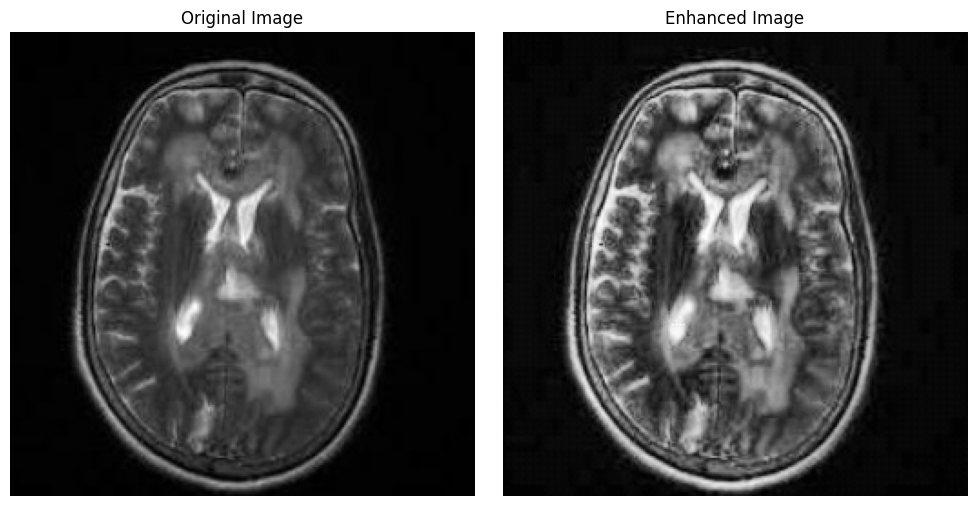

In [35]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

generator_path = "/content/optimized_pix2pix_model/generator_optimized.keras"
generator = tf.keras.models.load_model(generator_path, compile=False)

def load_and_preprocess_image(image_path, target_size=(256, 256)):
    img = Image.open(image_path).convert('L')
    img = img.resize(target_size)
    img_array = np.array(img).astype(np.float32) / 255.0
    img_array_expanded = np.expand_dims(img_array, axis=-1)  
    img_array_expanded = np.expand_dims(img_array_expanded, axis=0)  
    return img_array, img_array_expanded  

def apply_clahe_to_enhanced_image(enhanced_img_np):
    enhanced_np = enhanced_img_np.numpy()  
    enhanced_uint8 = (enhanced_np * 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(enhanced_uint8)
    return clahe_img


def visualize_original_and_enhanced(image_path):
    original_img, preprocessed_img = load_and_preprocess_image(image_path)
    enhanced_image = generator(preprocessed_img, training=False)
    enhanced_np = enhanced_image[0, :, :, 0]

    clahe_enhanced = apply_clahe_to_enhanced_image(enhanced_np)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(clahe_enhanced, cmap='gray')
    plt.title("Enhanced Image")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

image_path = '/content/combined_data/non_tumor/Te-no_0121.jpg' 
visualize_original_and_enhanced(image_path)


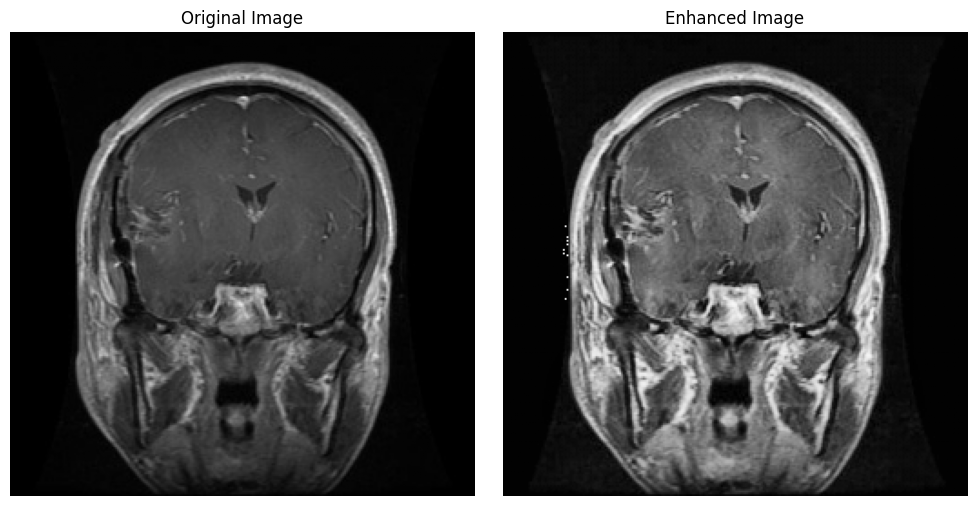

In [37]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

generator_path = "/content/optimized_pix2pix_model/generator_optimized.keras"
generator = tf.keras.models.load_model(generator_path, compile=False)

def load_and_preprocess_image(image_path, target_size=(256, 256)):
    img = Image.open(image_path).convert('L')
    img = img.resize(target_size)
    img_array = np.array(img).astype(np.float32) / 255.0
    img_array_expanded = np.expand_dims(img_array, axis=-1)  
    img_array_expanded = np.expand_dims(img_array_expanded, axis=0)  
    return img_array, img_array_expanded  

def apply_clahe_to_enhanced_image(enhanced_img_np):
    enhanced_np = enhanced_img_np.numpy()  
    enhanced_uint8 = (enhanced_np * 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(enhanced_uint8)
    return clahe_img


def visualize_original_and_enhanced(image_path):
    original_img, preprocessed_img = load_and_preprocess_image(image_path)
    enhanced_image = generator(preprocessed_img, training=False)
    enhanced_np = enhanced_image[0, :, :, 0]

    clahe_enhanced = apply_clahe_to_enhanced_image(enhanced_np)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(clahe_enhanced, cmap='gray')
    plt.title("Enhanced Image")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

image_path = '/content/combined_data/tumor/Te-gl_0038.jpg'
visualize_original_and_enhanced(image_path)


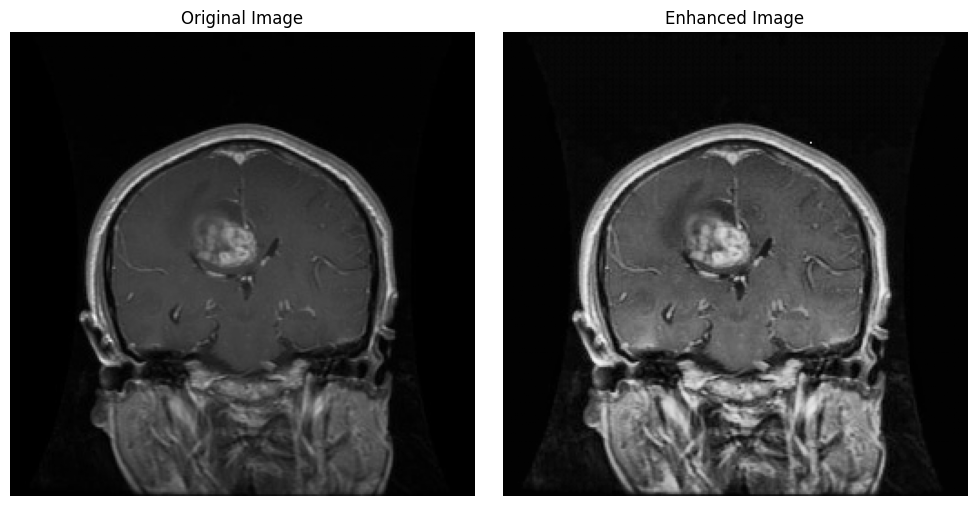

In [41]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

generator_path = "/content/optimized_pix2pix_model/generator_optimized.keras"
generator = tf.keras.models.load_model(generator_path, compile=False)

def load_and_preprocess_image(image_path, target_size=(256, 256)):
    img = Image.open(image_path).convert('L')
    img = img.resize(target_size)
    img_array = np.array(img).astype(np.float32) / 255.0
    img_array_expanded = np.expand_dims(img_array, axis=-1)
    img_array_expanded = np.expand_dims(img_array_expanded, axis=0) 
    return img_array, img_array_expanded  

def apply_clahe_to_enhanced_image(enhanced_img_np):
    enhanced_np = enhanced_img_np.numpy()  
    enhanced_uint8 = (enhanced_np * 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(enhanced_uint8)
    return clahe_img


def visualize_original_and_enhanced(image_path):
    original_img, preprocessed_img = load_and_preprocess_image(image_path)
    enhanced_image = generator(preprocessed_img, training=False)
    enhanced_np = enhanced_image[0, :, :, 0]

    clahe_enhanced = apply_clahe_to_enhanced_image(enhanced_np)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(clahe_enhanced, cmap='gray')
    plt.title("Enhanced Image")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

image_path = '/content/combined_data/tumor/Te-gl_0040.jpg'
visualize_original_and_enhanced(image_path)


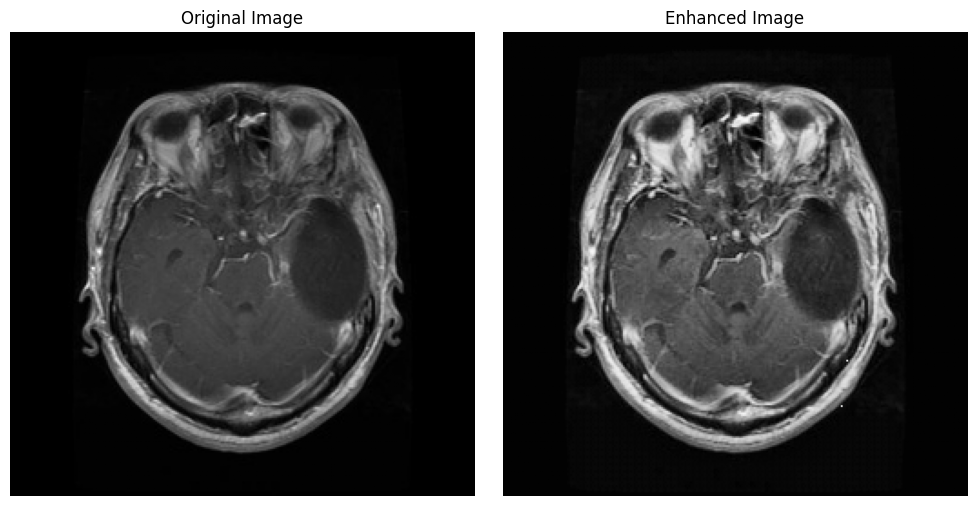

In [43]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

generator_path = "/content/optimized_pix2pix_model/generator_optimized.keras"
generator = tf.keras.models.load_model(generator_path, compile=False)

def load_and_preprocess_image(image_path, target_size=(256, 256)):
    img = Image.open(image_path).convert('L')
    img = img.resize(target_size)
    img_array = np.array(img).astype(np.float32) / 255.0
    img_array_expanded = np.expand_dims(img_array, axis=-1)  
    img_array_expanded = np.expand_dims(img_array_expanded, axis=0)  
    return img_array, img_array_expanded 

def apply_clahe_to_enhanced_image(enhanced_img_np):
    enhanced_np = enhanced_img_np.numpy()  
    enhanced_uint8 = (enhanced_np * 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(enhanced_uint8)
    return clahe_img


def visualize_original_and_enhanced(image_path):
    original_img, preprocessed_img = load_and_preprocess_image(image_path)
    enhanced_image = generator(preprocessed_img, training=False)
    enhanced_np = enhanced_image[0, :, :, 0]

    clahe_enhanced = apply_clahe_to_enhanced_image(enhanced_np)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(clahe_enhanced, cmap='gray')
    plt.title("Enhanced Image")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

image_path = '/content/combined_data/tumor/Te-gl_0015.jpg'
visualize_original_and_enhanced(image_path)


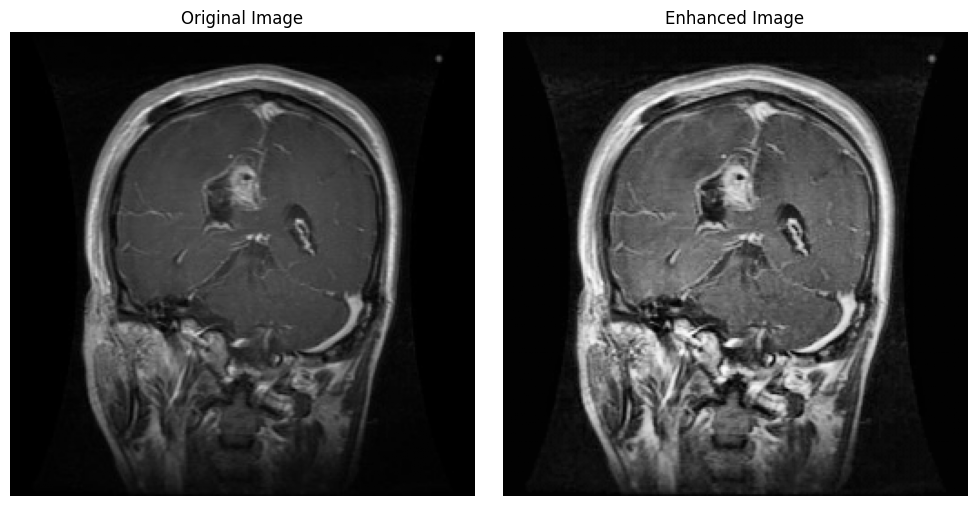

In [42]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

generator_path = "/content/optimized_pix2pix_model/generator_optimized.keras"
generator = tf.keras.models.load_model(generator_path, compile=False)

def load_and_preprocess_image(image_path, target_size=(256, 256)):
    img = Image.open(image_path).convert('L')
    img = img.resize(target_size)
    img_array = np.array(img).astype(np.float32) / 255.0
    img_array_expanded = np.expand_dims(img_array, axis=-1)  
    img_array_expanded = np.expand_dims(img_array_expanded, axis=0) 
    return img_array, img_array_expanded  

def apply_clahe_to_enhanced_image(enhanced_img_np):
    enhanced_np = enhanced_img_np.numpy()  
    enhanced_uint8 = (enhanced_np * 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(enhanced_uint8)
    return clahe_img


def visualize_original_and_enhanced(image_path):
    original_img, preprocessed_img = load_and_preprocess_image(image_path)
    enhanced_image = generator(preprocessed_img, training=False)
    enhanced_np = enhanced_image[0, :, :, 0]

    clahe_enhanced = apply_clahe_to_enhanced_image(enhanced_np)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(clahe_enhanced, cmap='gray')
    plt.title("Enhanced Image")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

image_path = '/content/combined_data/tumor/Te-gl_0059.jpg'
visualize_original_and_enhanced(image_path)


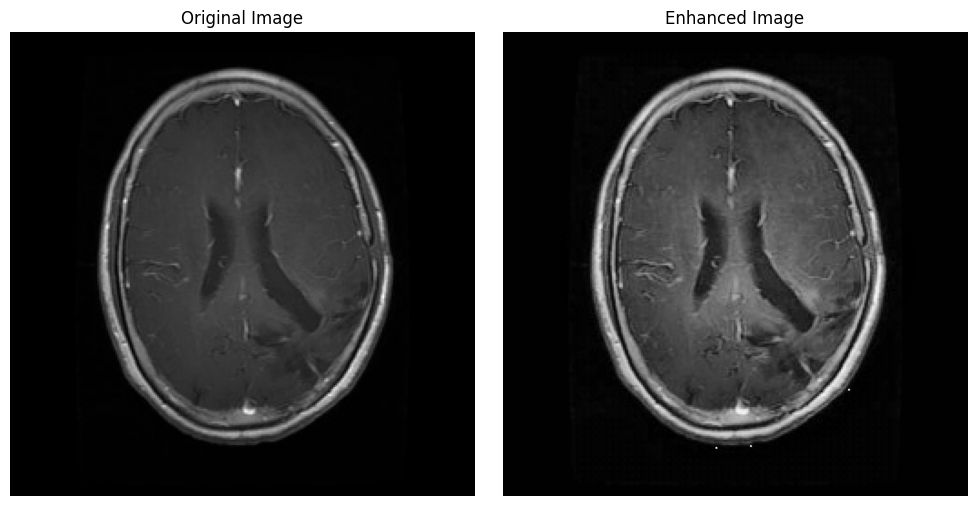

In [46]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# Load the saved generator model
generator_path = "/content/optimized_pix2pix_model/generator_optimized.keras"
generator = tf.keras.models.load_model(generator_path, compile=False)

# Load and preprocess image
def load_and_preprocess_image(image_path, target_size=(256, 256)):
    img = Image.open(image_path).convert('L')
    img = img.resize(target_size)
    img_array = np.array(img).astype(np.float32) / 255.0
    img_array_expanded = np.expand_dims(img_array, axis=-1)  # Add channel
    img_array_expanded = np.expand_dims(img_array_expanded, axis=0)  # Add batch
    return img_array, img_array_expanded  # Return original + batch

# Apply CLAHE
def apply_clahe_to_enhanced_image(enhanced_img_np):
    enhanced_np = enhanced_img_np.numpy()  # Convert from tensor to numpy
    enhanced_uint8 = (enhanced_np * 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(enhanced_uint8)
    return clahe_img


# Visualize both
def visualize_original_and_enhanced(image_path):
    original_img, preprocessed_img = load_and_preprocess_image(image_path)
    enhanced_image = generator(preprocessed_img, training=False)
    enhanced_np = enhanced_image[0, :, :, 0]

    clahe_enhanced = apply_clahe_to_enhanced_image(enhanced_np)

    # Plot both
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(clahe_enhanced, cmap='gray')
    plt.title("Enhanced Image")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
image_path = '/content/combined_data/tumor/Te-gl_0098.jpg'
visualize_original_and_enhanced(image_path)


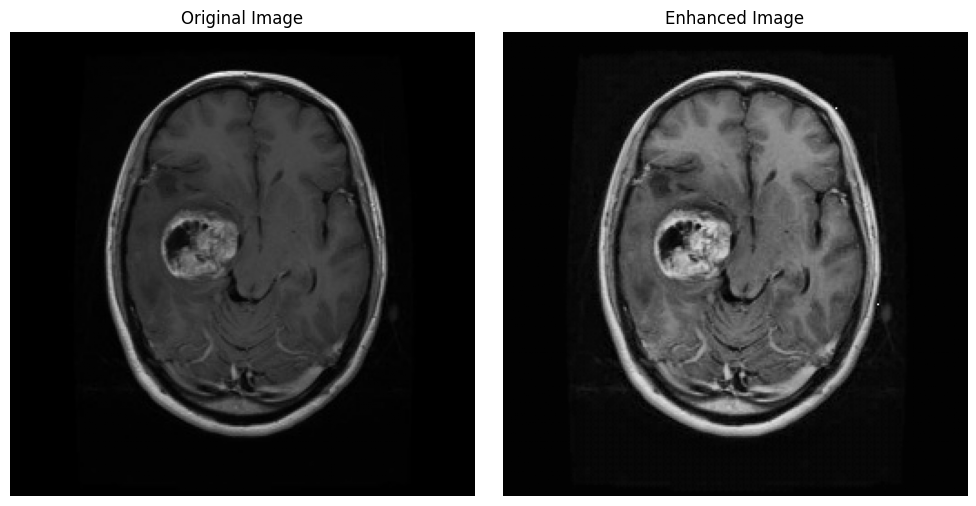

In [48]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# Load the saved generator model
generator_path = "/content/optimized_pix2pix_model/generator_optimized.keras"
generator = tf.keras.models.load_model(generator_path, compile=False)

# Load and preprocess image
def load_and_preprocess_image(image_path, target_size=(256, 256)):
    img = Image.open(image_path).convert('L')
    img = img.resize(target_size)
    img_array = np.array(img).astype(np.float32) / 255.0
    img_array_expanded = np.expand_dims(img_array, axis=-1)  # Add channel
    img_array_expanded = np.expand_dims(img_array_expanded, axis=0)  # Add batch
    return img_array, img_array_expanded  # Return original + batch

# Apply CLAHE
def apply_clahe_to_enhanced_image(enhanced_img_np):
    enhanced_np = enhanced_img_np.numpy()  # Convert from tensor to numpy
    enhanced_uint8 = (enhanced_np * 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(enhanced_uint8)
    return clahe_img


# Visualize both
def visualize_original_and_enhanced(image_path):
    original_img, preprocessed_img = load_and_preprocess_image(image_path)
    enhanced_image = generator(preprocessed_img, training=False)
    enhanced_np = enhanced_image[0, :, :, 0]

    clahe_enhanced = apply_clahe_to_enhanced_image(enhanced_np)

    # Plot both
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(clahe_enhanced, cmap='gray')
    plt.title("Enhanced Image")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
image_path = '/content/combined_data/tumor/Te-gl_0028.jpg'
visualize_original_and_enhanced(image_path)


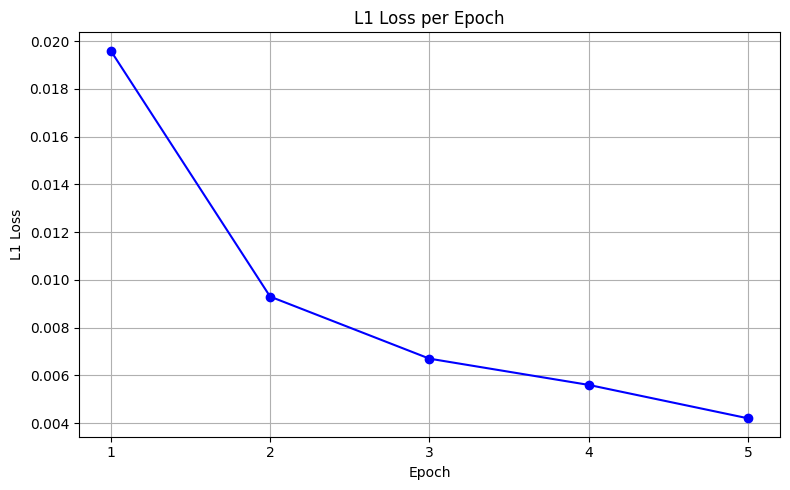

In [38]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5]
l1_loss_values = [0.0196, 0.0093, 0.0067, 0.0056, 0.0042]

plt.figure(figsize=(8, 5))
plt.plot(epochs, l1_loss_values, marker='o', color='blue', linestyle='-')
plt.title('L1 Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('L1 Loss')
plt.grid(True)
plt.xticks(epochs)
plt.tight_layout()
plt.show()

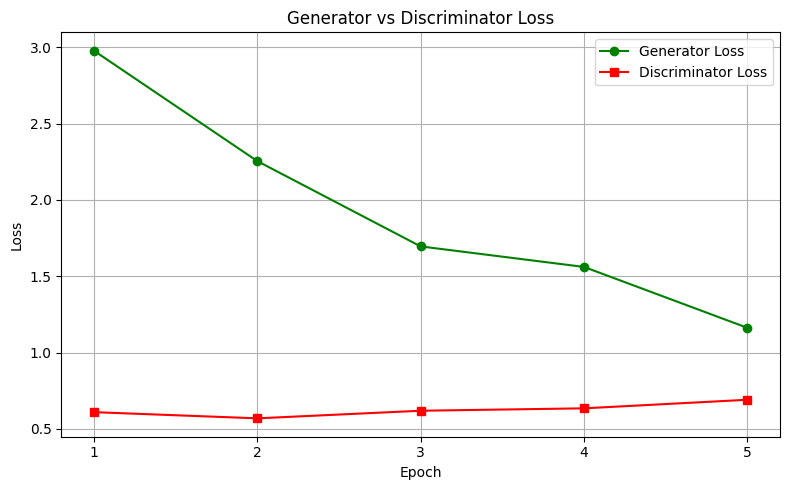

In [39]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5]
gen_loss_values = [2.9779, 2.2546, 1.6956, 1.5611, 1.1623]
disc_loss_values = [0.6095, 0.5690, 0.6188, 0.6346, 0.6907]

plt.figure(figsize=(8, 5))
plt.plot(epochs, gen_loss_values, marker='o', label='Generator Loss', color='green')
plt.plot(epochs, disc_loss_values, marker='s', label='Discriminator Loss', color='red')
plt.title('Generator vs Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.xticks(epochs)
plt.tight_layout()
plt.show()

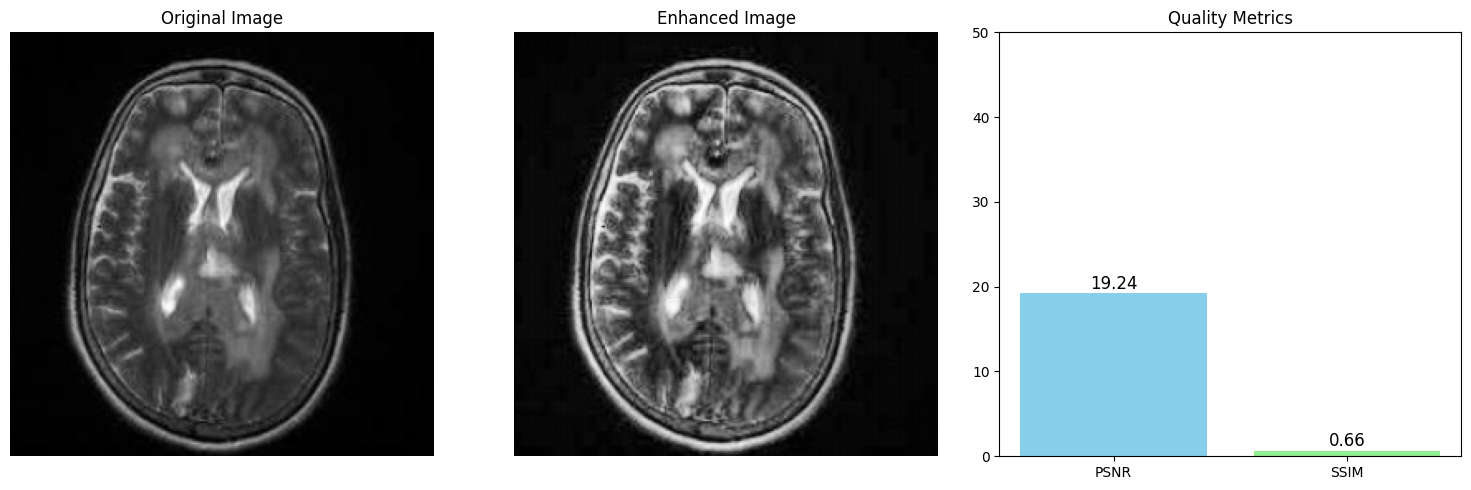

In [50]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import tensorflow as tf

generator_path = "/content/optimized_pix2pix_model/generator_optimized.keras"
generator = tf.keras.models.load_model(generator_path, compile=False)

image_path = '/content/combined_data/non_tumor/Te-no_0121.jpg'

original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
original = cv2.resize(original, (256, 256)) / 255.0
input_image = np.expand_dims(np.expand_dims(original, axis=-1), axis=0)

generated_image = generator(input_image, training=False)[0].numpy().squeeze()

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_image = clahe.apply((generated_image * 255).astype(np.uint8)) / 255.0

psnr_value = psnr(original, enhanced_image)
ssim_value = ssim(original, enhanced_image, data_range=1.0)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(original, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(enhanced_image, cmap='gray')
axs[1].set_title('Enhanced Image')
axs[1].axis('off')

axs[2].bar(['PSNR', 'SSIM'], [psnr_value, ssim_value], color=['skyblue', 'lightgreen'])
axs[2].set_title('Quality Metrics')
axs[2].set_ylim(0, max(50, psnr_value + 10))
for i, val in enumerate([psnr_value, ssim_value]):
    axs[2].text(i, val + 0.5, f"{val:.2f}", ha='center', fontsize=12)

plt.tight_layout()
plt.show()


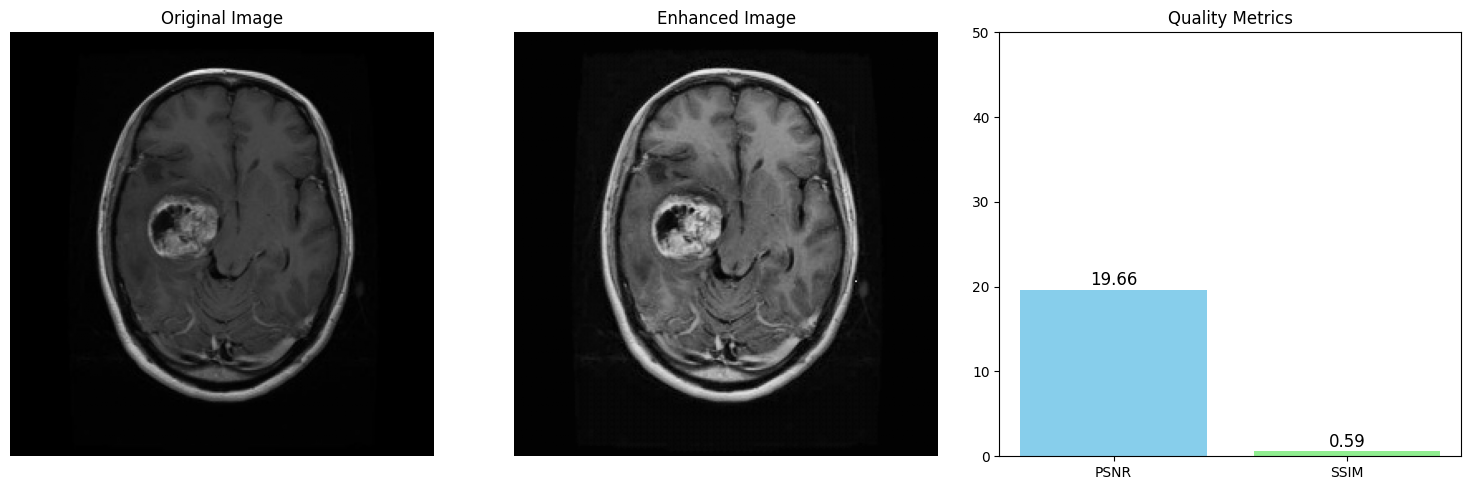

In [51]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import tensorflow as tf

generator_path = "/content/optimized_pix2pix_model/generator_optimized.keras"
generator = tf.keras.models.load_model(generator_path, compile=False)

image_path = '/content/combined_data/tumor/Te-gl_0028.jpg'

original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
original = cv2.resize(original, (256, 256)) / 255.0
input_image = np.expand_dims(np.expand_dims(original, axis=-1), axis=0)

generated_image = generator(input_image, training=False)[0].numpy().squeeze()

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_image = clahe.apply((generated_image * 255).astype(np.uint8)) / 255.0

psnr_value = psnr(original, enhanced_image)
ssim_value = ssim(original, enhanced_image, data_range=1.0)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(original, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(enhanced_image, cmap='gray')
axs[1].set_title('Enhanced Image')
axs[1].axis('off')

axs[2].bar(['PSNR', 'SSIM'], [psnr_value, ssim_value], color=['skyblue', 'lightgreen'])
axs[2].set_title('Quality Metrics')
axs[2].set_ylim(0, max(50, psnr_value + 10))
for i, val in enumerate([psnr_value, ssim_value]):
    axs[2].text(i, val + 0.5, f"{val:.2f}", ha='center', fontsize=12)

plt.tight_layout()
plt.show()


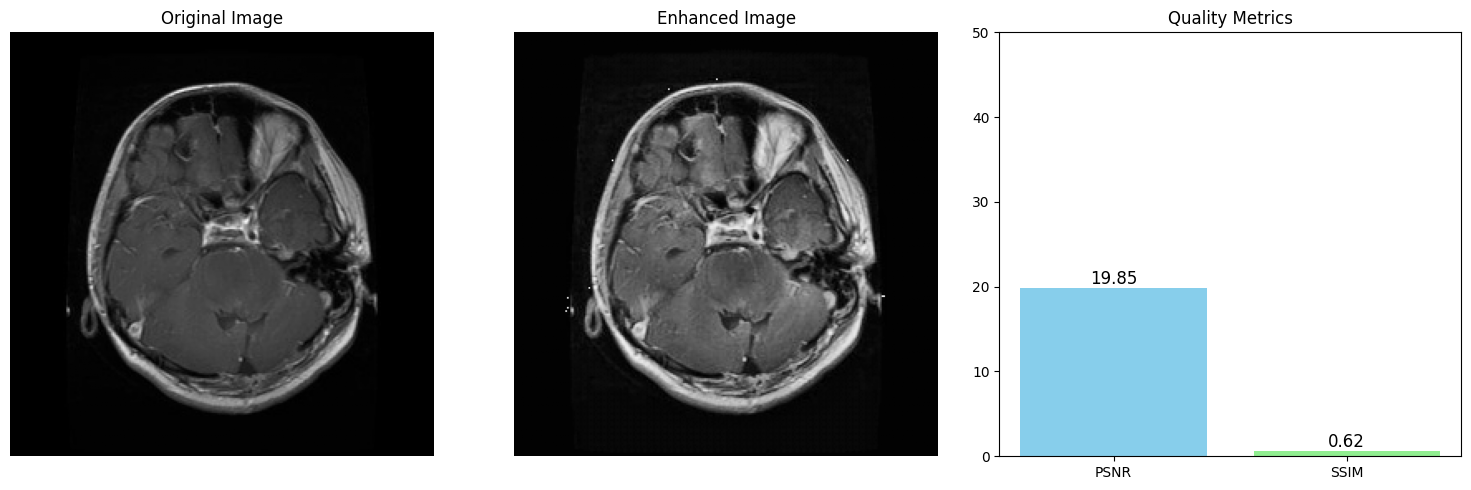

In [53]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import tensorflow as tf

generator_path = "/content/optimized_pix2pix_model/generator_optimized.keras"
generator = tf.keras.models.load_model(generator_path, compile=False)

image_path = '/content/combined_data/tumor/Te-gl_0010.jpg'

original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
original = cv2.resize(original, (256, 256)) / 255.0
input_image = np.expand_dims(np.expand_dims(original, axis=-1), axis=0)

generated_image = generator(input_image, training=False)[0].numpy().squeeze()

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_image = clahe.apply((generated_image * 255).astype(np.uint8)) / 255.0

psnr_value = psnr(original, enhanced_image)
ssim_value = ssim(original, enhanced_image, data_range=1.0)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(original, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(enhanced_image, cmap='gray')
axs[1].set_title('Enhanced Image')
axs[1].axis('off')

axs[2].bar(['PSNR', 'SSIM'], [psnr_value, ssim_value], color=['skyblue', 'lightgreen'])
axs[2].set_title('Quality Metrics')
axs[2].set_ylim(0, max(50, psnr_value + 10))
for i, val in enumerate([psnr_value, ssim_value]):
    axs[2].text(i, val + 0.5, f"{val:.2f}", ha='center', fontsize=12)

plt.tight_layout()
plt.show()
